# Exercise 4: The Very Achievable Exercise on Variational Autoencoders
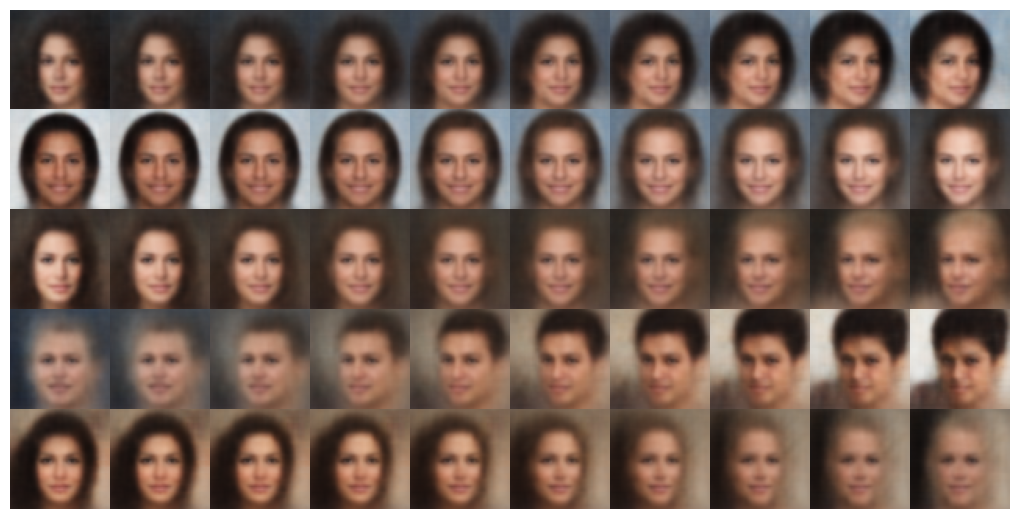
---
## Table of Contents
1. [Introduction](#introduction)
2. [Part I: MNIST](#part-i-mnist)
    - [Tool: Pytorch Lightning](#tool-pytorch-lightning)
3. [Part II: CelebA](#part-ii-celeba)

## Introduction

In this exercise, you will build and apply variational autoencoders to two datasets: [MNIST](https://yann.lecun.com/exdb/mnist/) (hand-written digits) and [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) (a collection of face datasets from celebrity images). While VAEs may no longer top the race in terms of generation quality compared to newer frameworks such as diffusion models, they remain a critical tool in various applications. VAEs are not only useful for data generation but also for tasks like anomaly detection, semi-supervised learning, and feature selection. In reinforcement learning, for instance, VAEs are employed to learn compact, informative representations of the environment, which can simplify state-space representations and improve policy learning. They also play a crucial role in disentangling latent features, aiding in interpretable and controllable generative processes.

> ⚠️ After pulling this exercise to your devcontainer, please execute `pip install -e .` in the terminal of the devcontainer at the directory `/workspaces/AE4353-Y24`.

## Part I: MNIST

As usual, we first load the hydra config for the experiment on MNIST.

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import torchvision.transforms as transforms
import lightning as L
from dotmap import DotMap
torch.manual_seed(42)

import hydra
from hydra.utils import instantiate
from omegaconf import OmegaConf


with hydra.initialize(version_base=None, config_path="./config"):
    cfg = hydra.compose(config_name="mnist_exp")
    # print(OmegaConf.to_yaml(cfg))

## Tool: PyTorch Lightning
As you may have noticed when working on previous exercises, there are quite a few common patterns in the code we write for training neural networks. For instance, we consistently implement a training loop that involves iterating over batches from a dataloader, moving data to the GPU, performing the forward pass, calculating the loss, invoking the optimizer, and updating model parameters. Similar patterns also arise during validation runs. Wouldn’t it be great if there were a library to handle this boilerplate code, allowing us to focus on the parts specific to our problem? That is exactly what [PyTorch Lightning](https://lightning.ai/) is designed to do.

PyTorch Lightning revolves around two core components: the `LightningModule` and the `Trainer`.

The `LightningModule` is where you define the architecture of your model and the key steps for training, validation, and testing. It organizes methods for the forward pass, calculating loss, defining optimizers, and logging metrics in a clean and modular way. This structure keeps your code organized and readable while ensuring flexibility when it comes to different tasks, such as tweaking the optimization strategy or logging custom metrics.

The `Trainer`, on the other hand, handles the entire training loop for you. It automates many of the boilerplate steps like iterating over batches, moving data to the GPU, checkpointing, handling distributed training (in an environment with multiple GPUs or multiple nodes in a cluster), and more. With a simple call to trainer.fit(), it will handle everything from training to validation and even testing, freeing you from having to manually implement and maintain these repetitive parts of the workflow.

Let's see how we can implement our VAE training using Lightning.

At the bare minimum, one need to implement the `training_step(self, batch, batch_idx)` method for a `LightningModule`. This method essentially captures the core of the training loop, including all the operations from when a batch is loaded to the return of the loss. One also needs to implement the `configure_optimizers` method to return an optimizer.

But there are many more methods you could optionally implement to achieve more functionalities. For example, here we implemented `validation_step` so that lightning would be able to use this method as the recipe for executing validation runs.

The other great feature PyTorch Lightning provides is **callback functions** (sometimes referred to as hooks). These are predefined functions that are executed at specific points during the training process. Lightning offers a wide variety of callbacks throughout the training pipeline, making it simple to add custom behavior without cluttering your LightningModule. By implementing features within the appropriate callback function, you can extend the pipeline—whether it’s for early stopping, logging, checkpointing, or custom actions like modifying learning rates—without polluting the core training logic.

For instance, if you want to perform a custom action when training starts, you can use the `on_train_start` callback. If you want to take action after every epoch, you can use `on_epoch_end`. These callbacks allow you to inject custom code at almost any point during training, validation, or testing. This modularity helps keep your code clean and maintainable, as the callbacks isolate auxiliary logic from the main model definition. You can even combine multiple callbacks, making your training process both flexible and scalable. For an overview of the callbacks lightning provides, see the screenshot below (note some of the callback functions might take a different name now in the latest versions). The docs for callbacks are at [here](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html#hooks).

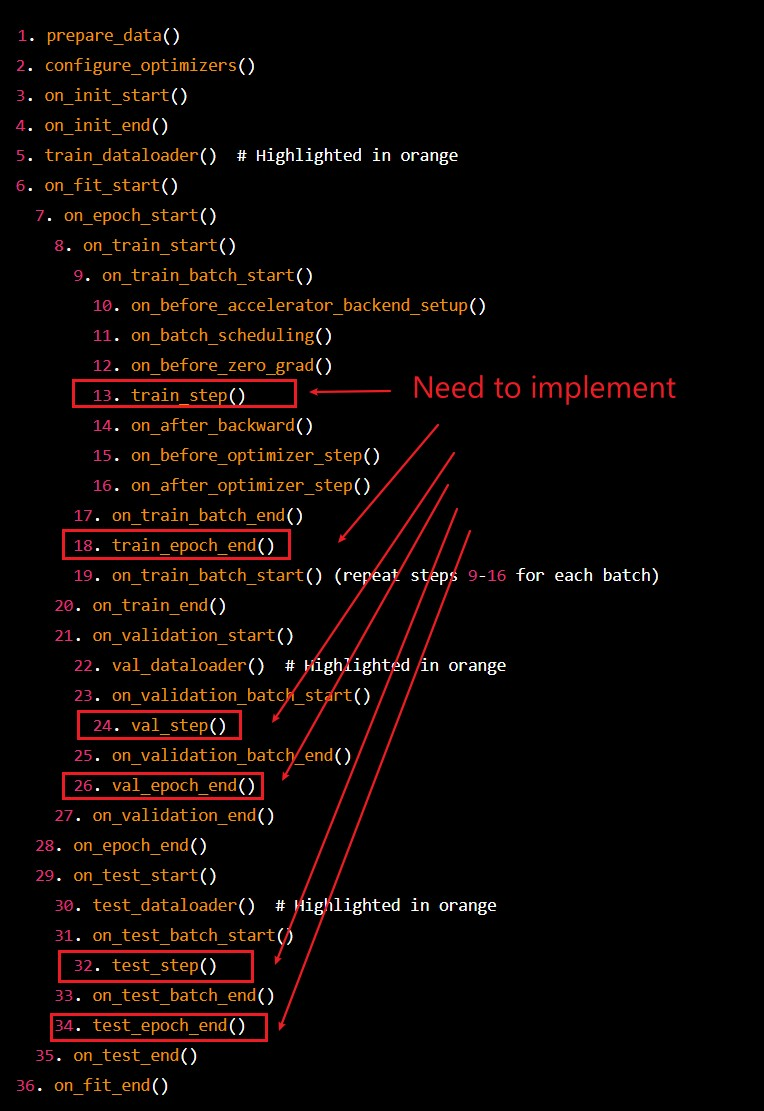

In our case, we implemented `on_validation_epoch_end` to visualize the generated samples, reconstructed samples and interpolated samples and log them using the logger, after each validation run is completed.

In [ ]:
class VAE(L.LightningModule):
    def __init__(self, model, cfg):
        super().__init__()
        self.model = model
        self.cfg = DotMap(cfg)
        self.save_hyperparameters(ignore=["model"])

    def training_step(self, batch, batch_idx):
        x, _ = batch
        out = self.model(x)
        loss = self.model.loss_fn(**out)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        out = self.model(x)

        if batch_idx == 0:
            # save the first batch for visualization
            self.val_samples = out

        loss = self.model.loss_fn(**out)
        self.log("val_loss", loss, prog_bar=True)

    def on_validation_epoch_end(self):
        # generation
        n_samples = 25
        z = torch.randn(n_samples, cfg.model.latent_dim, device=self.device)
        x_gen = self.model.decoder(z)

        grid = torchvision.utils.make_grid(x_gen, nrow=5)
        self.logger.experiment.add_image("generated samples", grid, self.current_epoch)

        # reconstruction
        n_samples = 10
        x, x_recon = self.val_samples["x"], self.val_samples["recon_x"]

        x_concat = torch.cat([x[0:5], x_recon[0:5], x[5:10], x_recon[5:10]], dim=0)
        grid = torchvision.utils.make_grid(x_concat, nrow=5)
        self.logger.experiment.add_image(
            "reconstructed samples", grid, self.current_epoch
        )

        # interpolation
        n_samples = 20
        x_interpolated = self.model.interpolate(x[0:10], x[10:20], 10)
        grid = torchvision.utils.make_grid(x_interpolated, nrow=10)
        self.logger.experiment.add_image(
            "interpolated samples", grid, self.current_epoch
        )

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.cfg.lr)

In [ ]:
model = instantiate(cfg.model)
vae = VAE(model, OmegaConf.to_container(cfg, resolve=True))

In [ ]:
mnist_trainset = torchvision.datasets.MNIST(
    root="../data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_trainset, [50000, 10000])
train_loader = instantiate(cfg.train_loader)(mnist_train)
val_loader = instantiate(cfg.val_loader)(mnist_val)

Lastly, we create the `Trainer`, and call `Trainer.fit` to launch the training run. Everything configured in the callbacks and trainer settings—such as running validation, saving checkpoints, logging, and more—will be executed automatically at the appropriate times in the pipeline. It’s that simple!

Note that the `Trainer` has many useful settings. For example, you can use **overfit_batches** to train the model on just a few batches, which is helpful for performing a quick sanity check on your model design. You can also adjust the **precision** to train with different numerical precision (such as 16-bit for faster computation). Additionally, you can control the **logging frequency** with `log_every_n_steps`, and manage **distributed training** across multiple devices using the `accelerator` argument, among many other configurable options. For a complete list of its configuration, see [here](https://lightning.ai/docs/pytorch/stable/common/trainer.html).

<strong style="color:red;">TODOs</strong>

For this exercise:
- First, finish the implementation of `DecoderResNetVAE` in `model.py`
- Next, implement the loss function of `BaseAE` in `vae.py`
- Train a vanilla autoencoder by setting `arch` to "ae" in `mnist_exp.yaml`
    - Tune the `latent_dim` in `model/ae_mnist.yaml`. What is the optimal latent_dim? Why might a larger `latent_dim` perform worse than a smaller one?
    - Do you get good reconstructions from an autoencoder?
    - What about generation? Is this expected?
- Aferwards, implement the loss function and the `sample_latent` method of `BetaVAE` in `vae.py`
- Train a VAE by setting `arch` to "vae" in `mnist_exp.yaml`
    - Start with the optimal `latent_dim` from the autoencoder experiment and finetune the dimension to achieve the lowest loss
    - Do you get good reconstruction? Is it better or worse than the autoencoder? Why?
    - What about generation? Is it better or worse than the autoencoder? Why?
    - Does the interpolated samples show any difference to the autoencoder one? What might cause the difference?


In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger

logger = TensorBoardLogger("runs", name=cfg.name, version=cfg.arch.type)
trainer = L.Trainer(logger=logger, limit_train_batches=1.0, max_epochs=cfg.max_epochs)
trainer.fit(vae, train_dataloaders=train_loader, val_dataloaders=val_loader)

After training, you can expect the following level of **reconstruction quality for AE**:

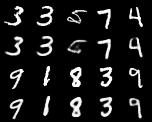

and the following level of **generation quality for VAE**:

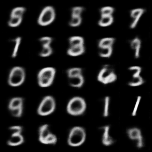

## Part II: CelebA

Once you are finished with MNIST, you can proceed to train VAEs on CelebA dataset. Download the dataset files from SURFDrive and unzip `img_align_celeba.zip`. Move onto the GPU for this experiment and tune the `latent_dim` for the best generation quality.

In [ ]:
with hydra.initialize(version_base=None, config_path="./config"):
    cfg = hydra.compose(config_name="celeba_exp")

In [ ]:
from torchvision.datasets import CelebA
from torchvision.transforms import (
    Compose,
    PILToTensor,
    ConvertImageDtype,
    CenterCrop,
    Resize,
)


transform = Compose(
    [PILToTensor(), ConvertImageDtype(torch.float32), CenterCrop(160), Resize(64)]
)


train_data = CelebA(
    "../data",
    split="train",
    download=False,
    transform=transform,
    target_type=[],
)
valid_data = CelebA(
    "../data",
    split="valid",
    download=False,
    transform=transform,
    target_type=[],
)

In [ ]:
def collate_fn(batch):
    images = [item[0] for item in batch]
    return torch.stack(images, dim=0), None


train_loader = instantiate(cfg.train_loader)(train_data, collate_fn=collate_fn)
val_loader = instantiate(cfg.val_loader)(valid_data, collate_fn=collate_fn)

In [ ]:
model = instantiate(cfg.model)
vae = VAE(model, OmegaConf.to_container(cfg, resolve=True))

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger

logger = TensorBoardLogger("runs", name=cfg.name, version=cfg.arch.type)
trainer = L.Trainer(logger=logger, limit_train_batches=1.0, max_epochs=cfg.max_epochs)
trainer.fit(vae, train_dataloaders=train_loader, val_dataloaders=val_loader)

With the correct configuration, you can expect to meet the following level of generation quality:
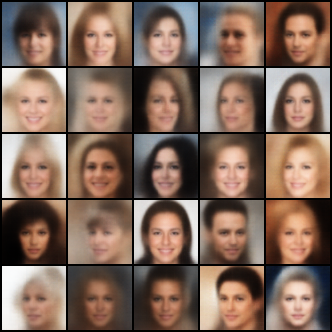